<a href="https://colab.research.google.com/github/Oshgig/FRAUD-DETECTION/blob/main/Project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string


from scipy.io import arff
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

from typing import List, Tuple

In [3]:
#Convert the arff file extension to a csv extension

def arff_to_csv(arff_file_path, csv_file_path):
    # Load the ARFF file
    data, meta = arff.loadarff(arff_file_path)

    # Create a DataFrame from the ARFF data
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)



In [4]:
# call the def and load the path for thr arff and create a folder for the csv file
arff_file_path = '/content/drive/MyDrive/LLM/phpKo8OWT.arff'
csv_file_path = '/content/drive/Othercomputers/My Mac/Desktop/project_code/fraud.csv'
arff_to_csv(arff_file_path, csv_file_path)


In [14]:
#Create a variable and read the csv file
df = pd.read_csv('/content/drive/Othercomputers/My Mac/Desktop/project_code/fraud.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,b'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,b'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,b'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,b'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,b'0'


In [15]:
#show the unique value of the class column
df['Class'].unique()

array(["b'0'", "b'1'"], dtype=object)

In [16]:
# Convert the Class unique value to an integer with replace function
df['Class'] = df['Class'].replace({"b'0'": 0, "b'1'": 1})
df['Class'].dtype

dtype('int64')

In [17]:
# Count the occurrences of fraud and no fraud and print them
#shows an high imbalance in the data
#where 0 is not_fraud and 1 is fraud
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [20]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


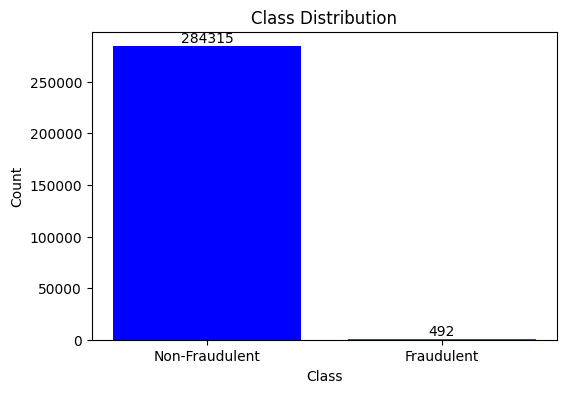

In [18]:
# Occurence of 0 and 1
class_counts = df['Class'].value_counts()


plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.index.astype(str), class_counts.values, color=['blue', 'red'])

# Add text annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1000, yval, ha='center', va='bottom', fontsize=10)

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Fraudulent', 'Fraudulent'])


plt.show()

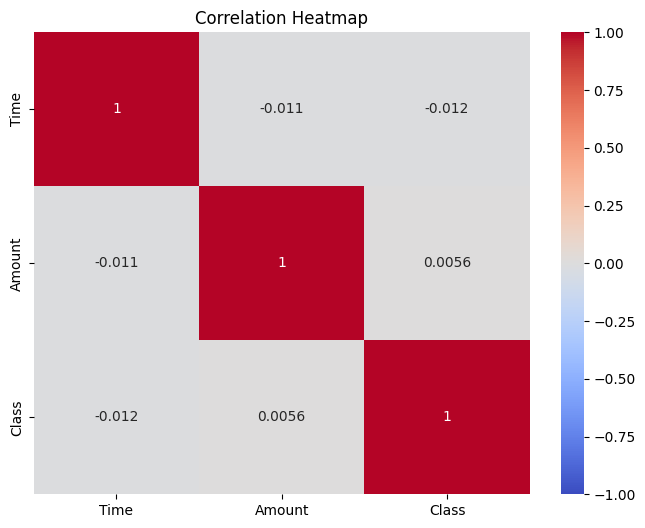

Correlation coefficients:
            Time    Amount     Class
Time    1.000000 -0.010596 -0.012323
Amount -0.010596  1.000000  0.005632
Class  -0.012323  0.005632  1.000000


In [19]:
correlation_matrix = df[['Time', 'Amount', 'Class']].corr()

# Plotting correlation matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Print correlation coefficients
print("Correlation coefficients:")
print(correlation_matrix)

In [29]:
def preparation_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: label column
    """
    x = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

In [30]:
# Define a function to create a scatter plot of our data and labels
#By visualizing the data, to see  how  fraud cases are scattered over the data
#It shows the distribution of fraud and non-fraud
def plot_df(x: np.ndarray, y: np.ndarray):
    plt.scatter(x[y == 0, 0], x[y == 0, 1], label="Non-Fraud", alpha=0.3, linewidth=0.1, c='g')
    plt.scatter(x[y == 1, 0], x[y == 1, 1], label="Fraud", alpha=0.3, linewidth=0.1, c='r')
    plt.legend()
    return plt.show()

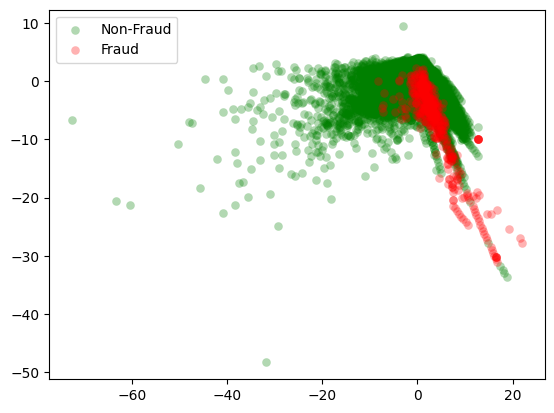

In [31]:
# Create x and y from the prep_data function
x, y = preparation_data(df)
# Plot our data by running our plot data function on X and y
plot_df(x, y)

In [58]:
#Use of SMOTE to improve balance in dataset
# Split the features and target variable
X = df.drop('Class', axis=1).values
y = df['Class']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution before and after SMOTE
print("Class distribution before SMOTE:", y_train.value_counts())
print("Class distribution after SMOTE:", pd.Series(y_train_resampled).value_counts())

Class distribution before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
Class distribution after SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


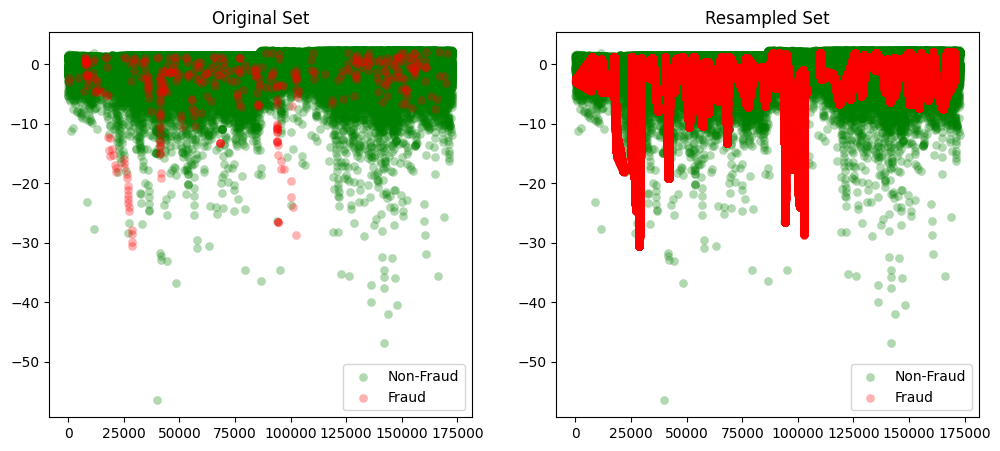

In [60]:
# Function to plot class distributions
def compare_plots(X, y, X_resampled, y_resampled, title1='Original Set', title2='Resampled Set'):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Non-Fraud", alpha=0.3, linewidth=0.15, c='g')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Fraud", alpha=0.3, linewidth=0.15, c='r')
    plt.title(title1)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Non-Fraud", alpha=0.3, linewidth=0.15, c='g')
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Fraud", alpha=0.3, linewidth=0.15, c='r')
    plt.title(title2)
    plt.legend()

    plt.show()

# Use the function to compare plots
compare_plots(X_train, y_train, X_train_resampled, y_train_resampled)